# Body Mass Index: Nature vs Nurture

The aim of this notebook is to model and identify factors associated with Body Mass Index (BMI), a quantitative parameter that is commonly used to diagnose obesity. By modeling BMI, I seek to identify which variables have a higher influence on having a higher BMI above the levels associated with obesity. To do this, the data will be fit to a linear regression model to analyze the magnitude of the coeficients.

The dataset is from Mendoza Palechor et al (2019), who collected data from an online survey from 2000 individuals, asking them about their weight, height and a number of lifestyle habits and antecedents of obesity in their family. The dataset can be downloaded here: https://www.kaggle.com/code/mpwolke/obesity-levels-life-style. More details about the dataset can be found at De la Hoz Correa et al (2019) (see references at the end of this notebook).

This notebook follows the 6 sequential steps of the Cross-Industry Standard Process for Data Mining (CRISP-DM), which are Business understanding, Data understanding, Data preparation, Modeling, Evaluation and Deployment.

## Business understanding

Here I explore the following 3 questions: 

1.- What's more important to having a high BMI: unhealthy lifestyle or genetics? There is a column 'has a family member who suffered or suffers from overweight' which we will use as a proxy of genetic influence. Also, there are several columns with info about eating behavior and physical exercise.

2.- Concerning lifestyle: What is more important for having a high BMI: unhealthy eating habits (including but not limited to overeating) or a sedentary lifestyle (lack of physical activity)?

3.- Intermitent fasting and weight management: recent findings suggest that intermitent fasting can be an effective strategy to lower weight. Is this reflected in the dataset? As there is a column asking "how many meals do you have daily?" and "if you eat between meals", this question could be potentially analyzed.

## Data understanding

In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [239]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### Dataset size

In [240]:
len(df)

2111

#### Column names

Let's rename columns to understand them easier

In [241]:
df.rename(columns={'Gender':'gender','Age':'age','Height':'height','Weight':'weight','family_history_with_overweight':'fam_hist_overweight', 'FAVC':'freq_high_cal_food', 'FCVC':'freq_vegs', 'NCP':'num_meals','CAEC':'food_betw_meals','SMOKE':'smoking','CH2O':'daily_H2O','CALC':'alcohol','SCC':'monit_calories','FAF':'freq_phys_act','TUE':'time_tech','MTRANS':'transportation','NObeyesdad':'obesity_level'},inplace=True)
df.head()

,gender,age,height,weight,fam_hist_overweight,freq_high_cal_food,freq_vegs,num_meals,food_betw_meals,smoking,daily_H2O,monit_calories,freq_phys_act,time_tech,alcohol,transportation,obesity_level
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The first 5 columns give standard characteristics and are easy to understand:

| Attribute | Column name | Possible values| 
| --- | --- | --- |
| Gender | gender | Female / Male |
| Age | age | Numeric value (years) |
| Height | height | Numeric value (meters) |
| Weight | weight| Numeric value (kilograms) |
| Family history with overweight | fam_hist_overweight | Yes / No |

In addition, there are columns that refer to attributes related with eating habits:

| Attribute | Column name | Possible values |
| --- | --- | --- |
| Frequent consumption of high caloric food | freq_high_cal_food | Yes / No |
| Frequency of consumption of vegetables | freq_vegs | Never / Sometimes / Always |
| Number of main meals | num_meals | 1 - 2 / 3 / >3 |
| Consumption of food between meals | food_betw_meals | No / Sometimes / Frequently / Always |
| Smoking | smoking | Yes / No |
| Consumption of water daily | daily_H2O | <1L / 1-2L / >2L |
| Consumption of alcohol | alcohol | Never / Sometimes / Frequently / Always |

And some additional columns contain attributes related with the physical condition:

| Attribute | Column name | Possible values |
| --- | --- | --- |
| Calories consumption monitoring | monit_calories | Yes / No |
| Physical activity frequency | freq_phys_act | Never / 1-2 days / 2-4 days / 4-5 days |
| Time using technology devices | time_tech | 0-2 hours / 3-5 hours / > 5 hours |
| Transportation used | transportation | Automobile / Motorbike / Bike / Public transportation / Walking |

#### Data encoding and data types

The original dataset contains a couple of numerical columns but most are categorical columns of 2 types: ordinal (the levels are ordered) and nominal (unordered levels), with 2 or more levels, as summarized below:

| Data type | Columns | Number of levels |
| --- | --- | --- |
| Numeric | age, weight, height, BMI | |
| Categorical nominal, binary | gender, family_hist_overweight, freq_high_cal_food, smoking, monit_calories | 2 levels |
| Categorical nominal, +2 levels | transportation | 5 levels |
| Categorical ordinal | freq_vegs, num_meals, food_betw_meals, daily_H2O, alcohol, freq_phys_act, time_tech | 3-4 levels |

I will later use a linear regression model using 2 different types of variable encoding for ordinal variables: 1) ordinal levels as independent categorical variables (in which each level of an ordinal variable will be treated as a 'yes/no' categorical variable) and 2) numerically encoding ordinal variables, in which the different levels will be encoded with an integer, thus retaining its intrinsic order (see later for pros and cons).
Anyhow, at this stage of data understanding, note that, in the dataset, some categorical columns are already encoded numerically (see cell below, which shows columns with object type data and does not include all columns with categorical data):

In [242]:
print("Values found in columns with object type data:")
print("------------------------------------------------")
for col in df.select_dtypes(include='object'):
  print("Column '" + str(col) + "' : " + str(df[col].unique()))

Values found in columns with object type data:
------------------------------------------------
Column 'gender' : ['Female' 'Male']
Column 'fam_hist_overweight' : ['yes' 'no']
Column 'freq_high_cal_food' : ['no' 'yes']
Column 'food_betw_meals' : ['Sometimes' 'Frequently' 'Always' 'no']
Column 'smoking' : ['no' 'yes']
Column 'monit_calories' : ['no' 'yes']
Column 'alcohol' : ['no' 'Sometimes' 'Frequently' 'Always']
Column 'transportation' : ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Column 'obesity_level' : ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Therefore, the columns 'freq_vegs', 'num_meals', 'daily_H2O', 'freq_phys_act' and 'time_tech' are categorical but are encoded numerically in the original dataset. Later this will be ammended.

In [243]:
cat_cols = ['gender','fam_hist_overweight','freq_high_cal_food', 'freq_vegs', 'num_meals', 'food_betw_meals', 'smoking', 'daily_H2O', 'monit_calories', 'freq_phys_act', 'time_tech', 'alcohol', 'transportation', 'obesity_level']
obj_type_cols = ['gender','fam_hist_overweight','freq_high_cal_food', 'food_betw_meals', 'smoking', 'monit_calories', 'alcohol', 'transportation', 'obesity_level']

In [244]:
print("Values found in categorical columns:")
print("------------------------------------------------")
for col in obj_type_cols:
  print("Column '" + str(col) + "' : " + str(df[col].unique()))

Values found in categorical columns:
------------------------------------------------
Column 'gender' : ['Female' 'Male']
Column 'fam_hist_overweight' : ['yes' 'no']
Column 'freq_high_cal_food' : ['no' 'yes']
Column 'food_betw_meals' : ['Sometimes' 'Frequently' 'Always' 'no']
Column 'smoking' : ['no' 'yes']
Column 'monit_calories' : ['no' 'yes']
Column 'alcohol' : ['no' 'Sometimes' 'Frequently' 'Always']
Column 'transportation' : ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Column 'obesity_level' : ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Let's visualize counts of all levels in all variables, to see that the dataset is unballanced for many variables.

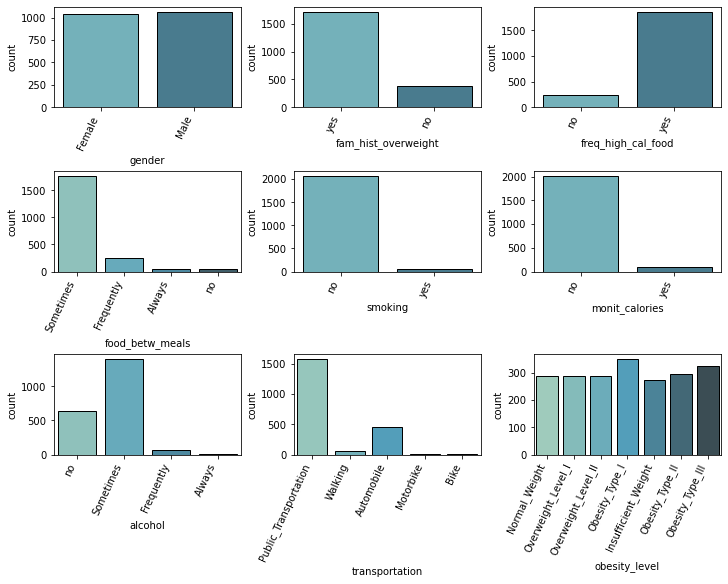

In [245]:
fig,ax = plt.subplots(3,3,figsize=(10,8),constrained_layout=True)
#sns.countplot(x= 'gender', data = df, palette="GnBu_d",edgecolor="black", ax=ax[0,0])
#sns.countplot(x= 'fam_hist_overweight', data = df, palette="GnBu_d",edgecolor="black", ax=ax[0,1])
#sns.countplot(x= 'freq_high_cal_food', data = df, palette="GnBu_d",edgecolor="black", ax=ax[0,2])

rows = [0,0,0,1,1,1,2,2,2]
cols = [0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,obj_type_cols):
    chart = sns.countplot(x= col_name, data = df, palette="GnBu_d",edgecolor="black", ax=ax[n_row,n_col])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
plt.show()

#### Anomalous data

6 columns have apparently anomalous values (histograms show intermediate values between levels of a same ordinal variable, see below)

In [246]:
anomalous_cols = ['freq_vegs','num_meals','daily_H2O','freq_phys_act','time_tech']

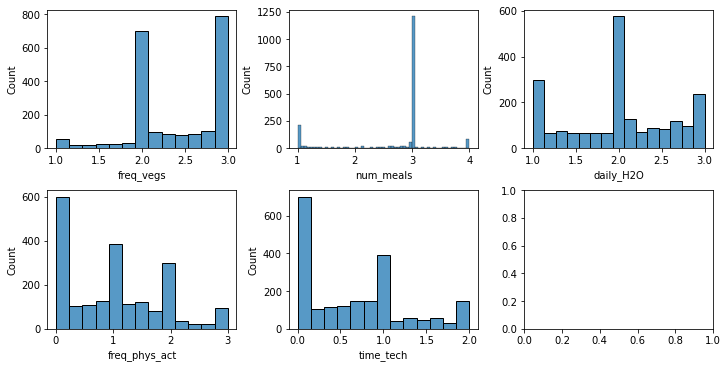

In [247]:
fig,ax = plt.subplots(2,3,figsize=(10,5),constrained_layout=True)
rows = [0,0,0,1,1,1,2,2,2]
cols = [0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,anomalous_cols):
    sns.histplot(x= col_name, data = df, palette="GnBu_d",edgecolor="black", ax=ax[n_row,n_col])
plt.show()

There is no explanation about these values in the original papers, beyond that synthetic data has been used to have a sufficiently sized dataset. Looking at the distribution, it seems the data spreads all over the range of possible values, suggesting they have been generated to produce variability. Thus, I will replace those values that are not integers with a rounded value so to approximate them to the nearest integer (see below). This way, the dataset will retain the variability.

#### Number of people in each class (obesity, non-obesity)

In [248]:
df['obesity_level'].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: obesity_level, dtype: int64

These results above show that the dataset is balanced across classes. Originally, the data obtained form surveys was not balanced, and since this could hamper data mining and machine learning methods, Mendoza et al 2019 added synthetic observations up to 77% of the data using the tool Weka and the filter SMOTE (see ref 8 in Mendoza et al 2019)

BMI is calculated as follows:

BMI = Weight / (Height * Height) (kg/m2)

After all calculation was made to obtain the mass body index for each individual, the results were compared with the data provided by WHO and the Mexican Normativity [7].

| Obesity level | BMI range |
| --- | --- |
| Underweight | < 18.5 |
| Normal | 18.5 - 24.9 |
| Overweight | 25.0 - 29.9 |
| Obesity I | 30.0 - 34.9 |
| Obesity II | 35.0 - 39.9 |
| Obesity III | > 40 |

#### Calculation of BMI

<AxesSubplot:xlabel='BMI', ylabel='Count'>

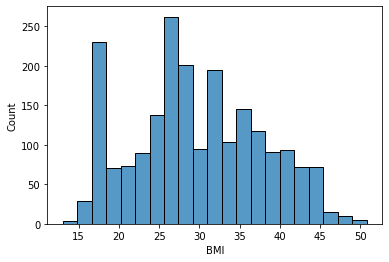

In [249]:
df['BMI'] = round(df['weight'] / (df['height'])**2,2)
sns.histplot(x= 'BMI', data = df, palette="GnBu_d",edgecolor="black")

Let's see how these values correspond to obesity levels:

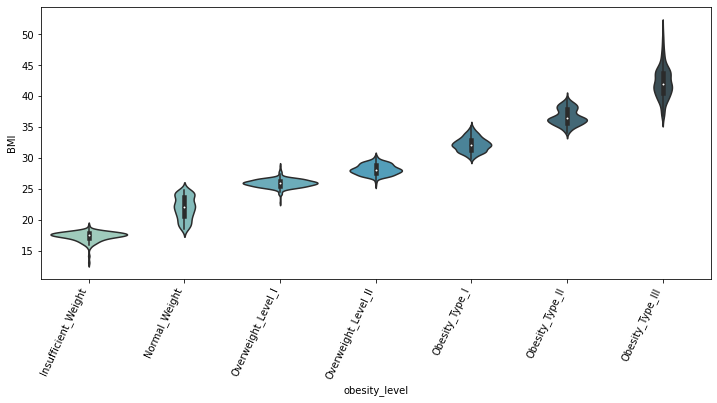

In [250]:
plt.figure(figsize=(12,5))
my_order = df.groupby(by=["obesity_level"])["BMI"].median().sort_values(ascending=False).iloc[::-1].index
chart = sns.violinplot(data=df,x='obesity_level',y='BMI', palette="GnBu_d",edgecolor="black", order=my_order)
chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
plt.show()

#### Missing values

The dataset has no missing values:

In [251]:
print("Number of missing values in each column:")
print("---------------------------------------")
for col in df.columns:
    print("Column '" + col + "' : " + str(df[col].isna().sum()))

Number of missing values in each column:
---------------------------------------
Column 'gender' : 0
Column 'age' : 0
Column 'height' : 0
Column 'weight' : 0
Column 'fam_hist_overweight' : 0
Column 'freq_high_cal_food' : 0
Column 'freq_vegs' : 0
Column 'num_meals' : 0
Column 'food_betw_meals' : 0
Column 'smoking' : 0
Column 'daily_H2O' : 0
Column 'monit_calories' : 0
Column 'freq_phys_act' : 0
Column 'time_tech' : 0
Column 'alcohol' : 0
Column 'transportation' : 0
Column 'obesity_level' : 0
Column 'BMI' : 0


## Data preparation

#### Creation of an obese binary column

For certain analysis, I will create one binary categorical column to aggregate all overweight and obesity levels in one same level:

In [252]:
df['obesity_binary'] = df['obesity_level'].apply(lambda x: 0 if x in ['Normal_Weight', 'Insufficient_Weight'] else 1)
df['obesity_binary_lbl'] = df['obesity_level'].apply(lambda x: 'no' if x in ['Normal_Weight', 'Insufficient_Weight'] else 'yes')
df.obesity_binary_lbl.value_counts()

yes    1552
no      559
Name: obesity_binary_lbl, dtype: int64

#### Imputing anomalous values in categorical variables

Here I approximate float values to the nearest integer in categorical columns encoded numerically with anomalous values, included above in the list 'anomalous cols'

In [253]:
int(round(1.6,0))

2

In [254]:
int(round(1.4,0))

1

In [255]:
anomalous_cols = ['freq_vegs','num_meals','daily_H2O','freq_phys_act','time_tech']
for col in anomalous_cols:
    df[col] = df[col].round(0).astype(int)

If everything is ok, now histograms should show no intermediate values

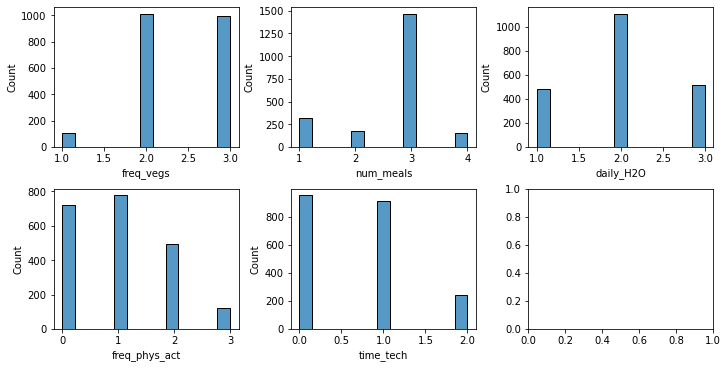

In [256]:
fig,ax = plt.subplots(2,3,figsize=(10,5),constrained_layout=True)
rows = [0,0,0,1,1,1,2,2,2]
cols = [0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,anomalous_cols):
    sns.histplot(x= col_name, data = df, palette="GnBu_d",edgecolor="black", ax=ax[n_row,n_col])
plt.show()

The column 'number_meals' has near 200 observations with a label '4', which do not correspond to the original description of the column in the paper, where it is said that this column can have any of the following: '1-2 meals', '3 meals', 'more than 3 meals'. Therefore, I assume those values with '4' are incorrectly assigned during synthetic data generation and I will approximate those to 3.

In [257]:
df['num_meals'] = df['num_meals'].replace(4,3)

Let's plot again to confirm the values look ok:

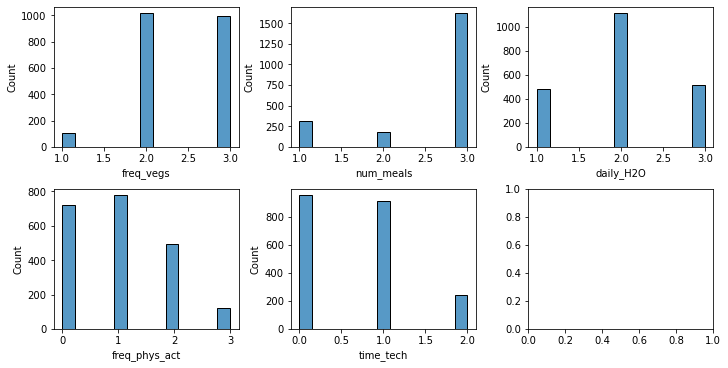

In [258]:
fig,ax = plt.subplots(2,3,figsize=(10,5),constrained_layout=True)
rows = [0,0,0,1,1,1,2,2,2]
cols = [0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,anomalous_cols):
    sns.histplot(x= col_name, data = df, palette="GnBu_d",edgecolor="black", ax=ax[n_row,n_col])
plt.show()

#### Converting integer categorical values to strings

To have consistent naming and encoding of columns for visualizations, I will create new columns to have the text label used in the survey, to facilitate interpretation of the analysis:

In [259]:
df['freq_vegs_lbl'] = df['freq_vegs'].replace(1,'Never').replace(2,'Sometimes').replace(3,'Always')
df['num_meals_lbl'] = df['num_meals'].replace(1, '1-2').replace(2,'3').replace(3,'>3')
df['daily_H2O_lbl'] = df['daily_H2O'].replace(1, '<1L').replace(2,'1L-2L').replace(3,'>2L')
df['freq_phys_act_lbl'] = df['freq_phys_act'].replace(0,'Never').replace(1,'1-2 days').replace(2,'2-4 days').replace(3,'4-5 days')
df['time_tech_lbl'] = df['time_tech'].replace(0,'0-2 hours').replace(1,'3-5 hours').replace(2,'>5 hours')

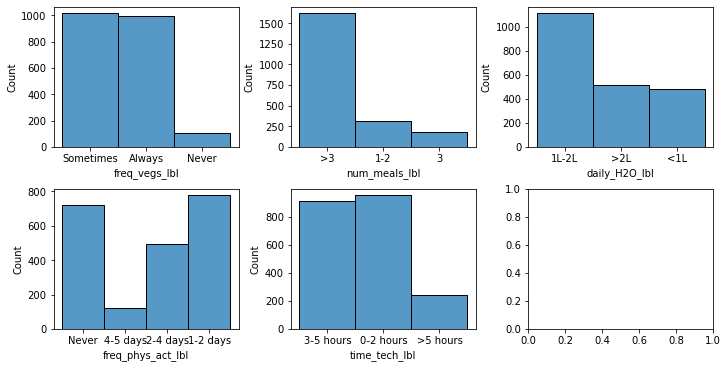

In [260]:
fig,ax = plt.subplots(2,3,figsize=(10,5),constrained_layout=True)
rows = [0,0,0,1,1,1,2,2,2]
cols = [0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,['freq_vegs_lbl','num_meals_lbl','daily_H2O_lbl','freq_phys_act_lbl','time_tech_lbl']):
    sns.histplot(x= col_name, data = df, palette="GnBu_d",edgecolor="black", ax=ax[n_row,n_col])
plt.show()

#### Visualizations

Let's visualize the relationship of our target variable, BMI, with the rest of variables in the dataset.

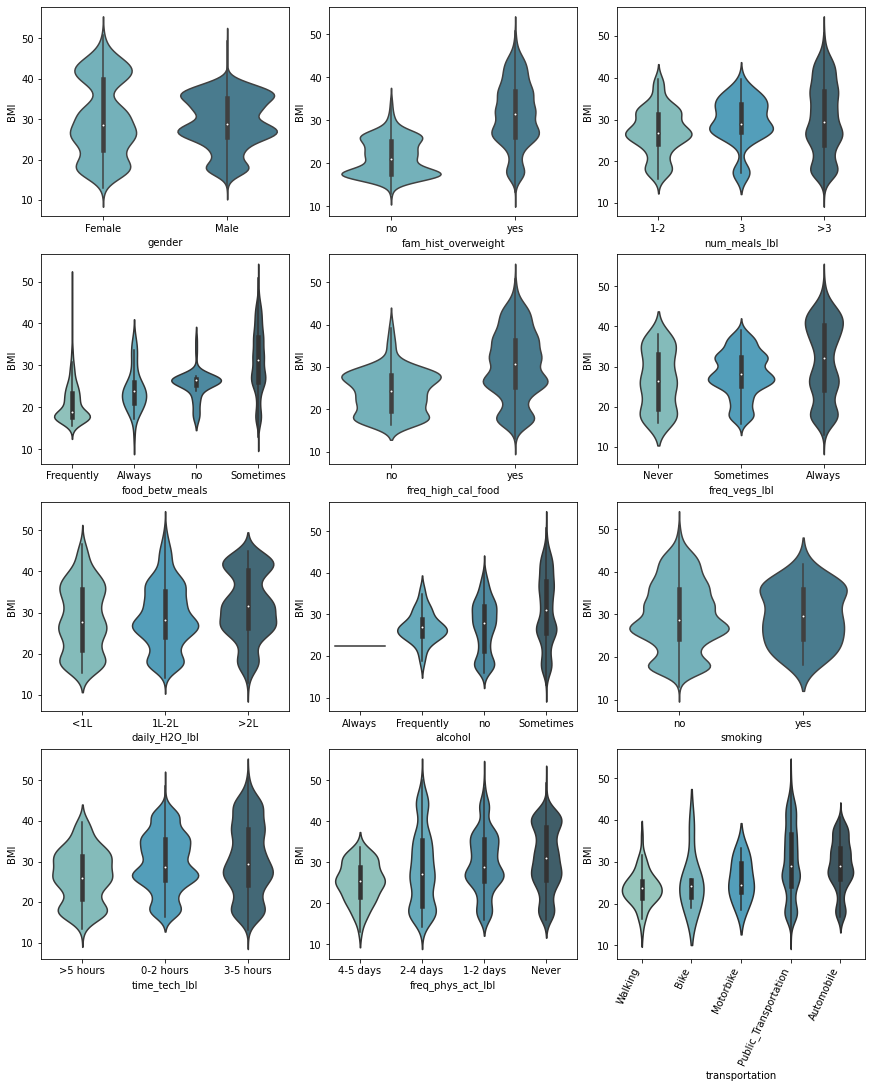

In [261]:
cols_vis = ['gender','fam_hist_overweight','num_meals_lbl','food_betw_meals','freq_high_cal_food','freq_vegs_lbl','daily_H2O_lbl','alcohol','smoking','time_tech_lbl','freq_phys_act_lbl','transportation']

fig,ax = plt.subplots(4,3,figsize=(12,15),constrained_layout=True)
rows = [0,0,0,1,1,1,2,2,2,3,3,3]
cols = [0,1,2,0,1,2,0,1,2,0,1,2]
for n_row,n_col,col_name in zip(rows,cols,cols_vis):
    my_order = df.groupby(by=[col_name])["BMI"].median().sort_values(ascending=False).iloc[::-1].index
    chart = sns.violinplot(data=df,x=col_name,y='BMI', palette="GnBu_d",edgecolor="black", order=my_order,ax=ax[n_row,n_col])
    if n_row==3 and n_col==2:
        chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
plt.show()

The variable 'family history with overweight' seems to have an interesting influence on BMI and obesity. Using our recently created 'obesity_binary' we can see that, while most individuals without family history of overweight are not obese nor overweight, on the contrary, most individuals with family history of overweight do have overweight or obesity.

<AxesSubplot:xlabel='fam_hist_overweight', ylabel='proportion'>

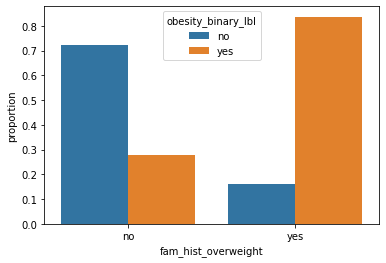

In [262]:
df[['obesity_binary_lbl','fam_hist_overweight']].groupby('fam_hist_overweight').value_counts(normalize=True).rename('proportion').reset_index().pipe((sns.barplot,'data'),x='fam_hist_overweight',y='proportion',hue='obesity_binary_lbl')

#### Encoding of levels within ordinal variables as independent categorical variables with dummy variables

As said, before, we will model data in 2 different ways using 2 different encoding strategies for ordinal variables. First, the different levels within each ordinal variable will be handled as a independent categorical variable, all of which will be encoded with a binnary dummy variable. In this way, I will not assume anything concering the quantitative relationship between the different levels of the ordinal variables in the dataset. This strategy will result in a total of 47 feature variables to add to the model. Since the size of the dataset is 2111, there are still at least 10 observations for each feature variable in the model. 

In [263]:
#selected_cols = ['BMI','obesity_level','age','gender','fam_hist_overweight','num_meals_lbl','food_betw_meals','freq_high_cal_food','freq_vegs_lbl','daily_H2O_lbl','alcohol','smoking','monit_calories','time_tech_lbl','freq_phys_act_lbl','transportation']
selected_cols = ['BMI','age','gender','fam_hist_overweight','num_meals_lbl','food_betw_meals','freq_high_cal_food','freq_vegs_lbl','daily_H2O_lbl','alcohol','smoking','monit_calories','time_tech_lbl','freq_phys_act_lbl','transportation']
df_cat = df[selected_cols]
df_cat.head()
cat_cols_final = [x for x in selected_cols if x not in ['age','BMI']]
#cat_cols_final
df_cat = pd.get_dummies(df_cat, columns = cat_cols_final)
df_cat.dtypes

BMI                                     float64
age                                     float64
gender_Female                             uint8
gender_Male                               uint8
fam_hist_overweight_no                    uint8
fam_hist_overweight_yes                   uint8
num_meals_lbl_1-2                         uint8
num_meals_lbl_3                           uint8
num_meals_lbl_>3                          uint8
food_betw_meals_Always                    uint8
food_betw_meals_Frequently                uint8
food_betw_meals_Sometimes                 uint8
food_betw_meals_no                        uint8
freq_high_cal_food_no                     uint8
freq_high_cal_food_yes                    uint8
freq_vegs_lbl_Always                      uint8
freq_vegs_lbl_Never                       uint8
freq_vegs_lbl_Sometimes                   uint8
daily_H2O_lbl_1L-2L                       uint8
daily_H2O_lbl_<1L                         uint8
daily_H2O_lbl_>2L                       

#### Encoding ordinal variables numerically

For comparison, I will also model the data using ordinal columns encoded numerically. This offers the advantage that the quantitative relationhsip between levels within ordinal variables is included in the model. The drawback is that I will be assumming that the distance between levels is similar.

Let's go through all variables one by one replacing values with integers, creating new variables for this purpose.

In [264]:
df.dtypes

gender                  object
age                    float64
height                 float64
weight                 float64
fam_hist_overweight     object
freq_high_cal_food      object
freq_vegs                int32
num_meals                int32
food_betw_meals         object
smoking                 object
daily_H2O                int32
monit_calories          object
freq_phys_act            int32
time_tech                int32
alcohol                 object
transportation          object
obesity_level           object
BMI                    float64
obesity_binary           int64
obesity_binary_lbl      object
freq_vegs_lbl           object
num_meals_lbl           object
daily_H2O_lbl           object
freq_phys_act_lbl       object
time_tech_lbl           object
dtype: object

In [265]:
df['food_betw_meals'].value_counts()
df['food_betw_meals_num'] = df['food_betw_meals'].replace('no',0).replace('Sometimes',1).replace('Frequently',2).replace('Always',3)
df['food_betw_meals_num'].value_counts()
#df['food_betw_meals'].value_counts()

1    1765
2     242
3      53
0      51
Name: food_betw_meals_num, dtype: int64

In [266]:
df['alcohol'].value_counts()
df['alcohol_num'] = df['alcohol'].replace('no',0).replace('Sometimes',1).replace('Frequently',2).replace('Always',3)
df['alcohol_num'].value_counts()

1    1401
0     639
2      70
3       1
Name: alcohol_num, dtype: int64

In [267]:
#df['obesity_level'].value_counts()
#df['obesity_level_num'] = df['obesity_level'].replace('Insufficient_Weight',0).replace('Normal_Weight',1).replace('Overweight_Level_I',2).replace('Overweight_Level_II',3).replace('Obesity_Type_I',4).replace('Obesity_Type_II',5).replace('Obesity_Type_III',6)

In [268]:
df['fam_hist_overweight'].value_counts()
df['fam_hist_overweight_num'] = df['fam_hist_overweight'].replace('no',0).replace('yes',1)

In [269]:
df['freq_high_cal_food'].value_counts()
df['freq_high_cal_food_num'] = df['freq_high_cal_food'].replace('no',0).replace('yes',1)

In [270]:
df['smoking'].value_counts()
df['smoking_num'] = df['smoking'].replace('no',0).replace('yes',1)

In [271]:
df['monit_calories'].value_counts()
df['monit_calories_num'] = df['monit_calories'].replace('no',0).replace('yes',1)

In [272]:
df['transportation'].value_counts()
df['transportation_active_num'] = df['transportation'].replace('Automobile',0).replace('Public_Transportation',0).replace('Motorbike',0).replace('Bike',1).replace('Walking',1)

In [273]:
#selected_cols = ['BMI','obesity_level_num','age','gender','fam_hist_overweight_num','num_meals','food_betw_meals_num','freq_high_cal_food_num','freq_vegs','daily_H2O','alcohol_num','smoking_num','monit_calories_num','time_tech','freq_phys_act','transportation_active_num']
selected_cols = ['BMI','age','gender','fam_hist_overweight_num','num_meals','food_betw_meals_num','freq_high_cal_food_num','freq_vegs','daily_H2O','alcohol_num','smoking_num','monit_calories_num','time_tech','freq_phys_act','transportation_active_num']
df_ord = df[selected_cols]
dummy_cols = ['gender']
df_ord = pd.get_dummies(df_ord, columns = dummy_cols)
df_ord.dtypes

BMI                          float64
age                          float64
fam_hist_overweight_num        int64
num_meals                      int32
food_betw_meals_num            int64
freq_high_cal_food_num         int64
freq_vegs                      int32
daily_H2O                      int32
alcohol_num                    int64
smoking_num                    int64
monit_calories_num             int64
time_tech                      int32
freq_phys_act                  int32
transportation_active_num      int64
gender_Female                  uint8
gender_Male                    uint8
dtype: object

Let's make all columns same integer type

In [274]:
int_cols = [x for x in df_ord.columns if x not in ['BMI','age']]
#int_cols
for col in int_cols:
    #print(col)
    df_ord[col]=df_ord[col].astype('int64')
df_ord.dtypes

BMI                          float64
age                          float64
fam_hist_overweight_num        int64
num_meals                      int64
food_betw_meals_num            int64
freq_high_cal_food_num         int64
freq_vegs                      int64
daily_H2O                      int64
alcohol_num                    int64
smoking_num                    int64
monit_calories_num             int64
time_tech                      int64
freq_phys_act                  int64
transportation_active_num      int64
gender_Female                  int64
gender_Male                    int64
dtype: object

## Modeling

#### Modeling 1: levels of ordinal variables as independent categorical variables

In [275]:
#Split into explanatory and response variables
X = df_cat.drop(columns='BMI')
y = df_cat['BMI']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
# Fit model
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

C:\Users\jvios\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


'The r-squared score for the model was 0.5007170689937646 on 634 values.'

Now let's analyze the coefficients

In [276]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
15,freq_vegs_lbl_Never,-1.162672e+14,1.162672e+14
16,freq_vegs_lbl_Sometimes,-1.162672e+14,1.162672e+14
14,freq_vegs_lbl_Always,-1.162672e+14,1.162672e+14
11,food_betw_meals_no,7.126053e+13,7.126053e+13
10,food_betw_meals_Sometimes,7.126053e+13,7.126053e+13
8,food_betw_meals_Always,7.126053e+13,7.126053e+13
9,food_betw_meals_Frequently,7.126053e+13,7.126053e+13
3,fam_hist_overweight_no,-6.746985e+13,6.746985e+13
4,fam_hist_overweight_yes,-6.746985e+13,6.746985e+13
25,smoking_yes,-6.654790e+13,6.654790e+13


#### Modeling 2: ordinal variables encoded numerically

In [277]:
#Split into explanatory and response variables
X = df_ord.drop(columns='BMI')
y = df_ord['BMI']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
# Fit model
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

C:\Users\jvios\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


'The r-squared score for the model was 0.4317523282389907 on 634 values.'

Now let's see the coefficients

In [278]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
1,fam_hist_overweight_num,7.668580,7.668580
3,food_betw_meals_num,-3.980239,3.980239
5,freq_vegs,2.994596,2.994596
9,monit_calories_num,-2.816015,2.816015
12,transportation_active_num,-2.367577,2.367577
7,alcohol_num,1.859643,1.859643
4,freq_high_cal_food_num,1.804523,1.804523
2,num_meals,0.987873,0.987873
11,freq_phys_act,-0.891646,0.891646
13,gender_Female,0.483619,0.483619


Let's make some visuals to better grasp the coefficients table above:

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


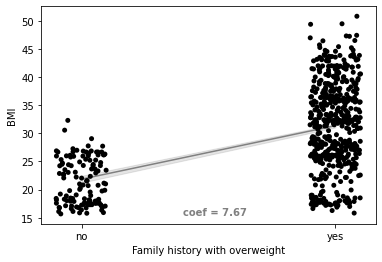

In [279]:
sns.stripplot(x= X_test['fam_hist_overweight_num'].replace(0,'no').replace(1,'yes'), y=y_test, order=['no','yes'],color='black')
sns.lineplot(X_test['fam_hist_overweight_num'], y_test_preds, color="grey")
plt.text(0.4, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='fam_hist_overweight_num']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Family history with overweight')
plt.show()

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


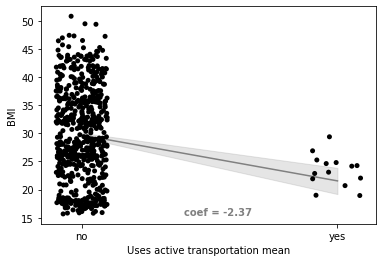

In [280]:
sns.stripplot(x= X_test['transportation_active_num'].replace(0,'no').replace(1,'yes'), y=y_test, order=['no','yes'],color='black')
sns.lineplot(X_test['transportation_active_num'], y_test_preds, color="grey")
plt.text(0.4, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='transportation_active_num']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Uses active transportation mean')
plt.show()

In [281]:
X_test['freq_phys_act'].value_counts()

0    223
1    212
2    158
3     41
Name: freq_phys_act, dtype: int64

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


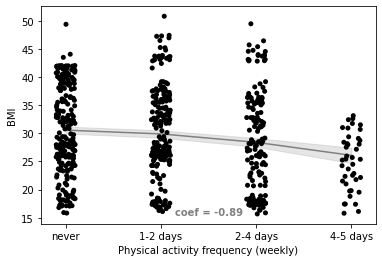

In [282]:
sns.stripplot(x= X_test['freq_phys_act'].replace(0,'never').replace(1,'1-2 days').replace(2,'2-4 days').replace(3,'4-5 days'), y=y_test, order=['never','1-2 days','2-4 days','4-5 days'],color='black')
sns.lineplot(X_test['freq_phys_act'], y_test_preds, color="grey")
plt.text(1.15, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='freq_phys_act']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Physical activity frequency (weekly)')
plt.show()

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


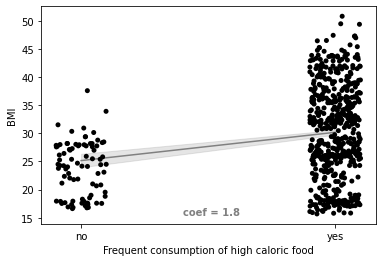

In [283]:
sns.stripplot(x= X_test['freq_high_cal_food_num'].replace(0,'no').replace(1,'yes'), y=y_test, order=['no','yes'],color='black')
sns.lineplot(X_test['freq_high_cal_food_num'], y_test_preds, color="grey")
plt.text(0.4, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='freq_high_cal_food_num']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Frequent consumption of high caloric food')
plt.show()

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


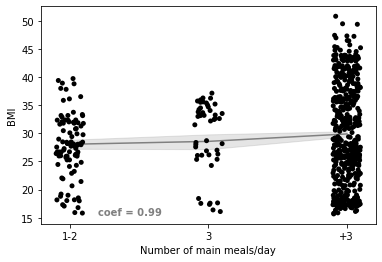

In [284]:
sns.stripplot(x= X_test['num_meals'].replace(1,'1-2').replace(2,'3').replace(3,'+3'), y=y_test, order=['1-2','3','+3'],color='black')
#sns.stripplot(x= X_test['num_meals'].replace(1,0).replace(2,1).replace(3,2), y=y_test,color='black')
sns.lineplot(X_test['num_meals'].replace(1,0).replace(2,1).replace(3,2), y_test_preds, color="grey")
plt.text(0.2, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='num_meals']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Number of main meals/day')
plt.show()

C:\Users\jvios\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


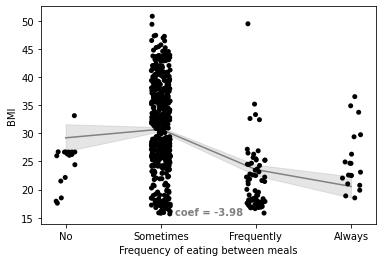

In [285]:
sns.stripplot(x= X_test['food_betw_meals_num'].replace(0,'No').replace(1,'Sometimes').replace(2,'Frequently').replace(3,'Always'),y=y_test,color='black',order=['No','Sometimes','Frequently','Always'])
#sns.stripplot(x= X_test['num_meals'].replace(1,0).replace(2,1).replace(3,2), y=y_test,color='black')
sns.lineplot(X_test['food_betw_meals_num'], y_test_preds, color="grey")
plt.text(1.15, 15.5, "coef = " + str(round(coef_df.loc[coef_df['est_int']=='food_betw_meals_num']['coefs'].values[0],2)), horizontalalignment='left', size='medium', color='grey', weight='semibold')
plt.xlabel('Frequency of eating between meals')
plt.show()

## Evaluation and discussion

In summary, I have used 2 different feature encoding approaches, keeping levels within ordinal variables as independent categorical variables or keeping ordinal variables as 1 single numerically encoded variable (assuming equal distances between levels within an ordinal variable), to fit a linear regression model. The R2 values show that both approaches, however, fit the data quite poorly (R2 around 0.5). Nevertheless, we can still draw some conclusions based on the analysis and visualizations created here. 

To answer the first question, 'what's more important to having a high BMI: unhealthy lifestyle or genetics?' we can look to the model using numerical encoding of variables, were we see that family history of overweight is the strongest predictor of BMI among the analyzed features, with a coefficient of over 7. Thus, this data supports the view that genetics play an important role in having a high BMI, in accordance to recent biomedical research (Loos F et al 2022, see below). In this line, Violin plots for BMI also showed a clear relationship between family history and BMI. Also interestingly, in this data, apparently unhealthy eating habits such as eating between meals and a low frequency of eating vegetables are both uncorrelated with a high BMI, which underscores the view that obesity is not necesarily the consequence of bad lifestyle choices but could, on the contrary, be a consequence of a built-in predisposition to gain weight easier.

On the other hand, there are also lifestyle parameters that seem to be associated with a higher BMI, such as not using active transportation methods, frequent alcohol consumption, a high frequency of eating high caloric food and a lower frequency of physical activity.

Concerning the second question, whether unhealthy eating habits (including but not limited to overeating) or a sedentary lifestyle (lack of physical activity) contribute more to a high BMI, again looking at the coefficients table reveals that eating habits appear to have a higher influence. For instance, the feature variable 'frequency of eating vegetables' has a coefficient of around 3 and 'eating between meals' has a negative coefficient of -4. These are 2 feature variables related with eating habits. On the other hand, feature variables related with an active lifestyle, such as 'using an active transportation mean', which has a coeficient of -2, and 'frequency of physicial activity', which has a coefficient of -0.9, seemingly have lower linear regression coeficients, suggesting that their impact on BMI is more modest. Therefore, even if both group of factors, eating and active lifestyle habits, do have an influence on having a high BMI, attributes related with eating seem to have a higher impact.

Finally, the third question asked if intermitent fasting predicts a lower BMI, as recent research suggest (De cabo R et al (2019). Looking at the coefficient of the 'number of meals' attribute does show a positive association with BMI. Also, eating between meals has a negative association with BMI. Therefore, this data does not support that fasting can help controlling weight. However, the level of 1 single meal/day was not directly encoded in the variable 'number of daily meals', therefore it cannot be directly assessed.

Call to action: we should discard the view that obesity is the consequence of bad lifestyle choices. However, lifestyle habits still are a crucial element to improve and can bring important health benefits to people with obesity or overweight. Weight management approaches via behavioral counselling should emphasize the reduction of high caloric food intake and alcohol while increasing physicial exercise and the adoption of an active lifestyle, according to this data.

Limitations of this analysis: the dataset is not balanced across levels in many ordinal variables, which weakens linear regression. Also, as seen in some plots, some variables are not linearly related with BMI, which is also consistent with the weird results of the linear regression when using dummy variables for the levels of ordinal variables, where oftentimes the different levels of a same variable have all an influence towards the same direction (suggesting perhaps curvilinear relationhips between the variable and BMI). Finally, linear regression on numerically encoded ordinal variables assumes that the distance between levels of ordinal variables are similar, which in some cases was not true. Therefore, altogether, I believe that an alternative modeling technique can be more appropriate to analyze this dataset.

## Deployment

A blog post discussing the entire modeling process and the main conclusions derived from the analysis can be found here: https://jvros.com.es/index.php/en/on-the-roots-of-overweight-nature-or-nurture/

The GitHub repository containing this notebook is here: https://github.com/jviosca/body_mass_index

## References

1.- Mendoza Palechor F & de la Hoz Manotas A (2019): Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. Data in brief 25(104344). https://doi.org/10.1016/j.dib.2019.104344

2.- De La Hoz Correa F et al (2019): Obesity Level Estimation Software based on Decision Trees. Journal of Computer Science, 15(1): 66-77. https://doi.org/10.3844/jcssp.2019.67.77

3.- Obesity Levels & Life Style. Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. https://www.kaggle.com/code/mpwolke/obesity-levels-life-style

4.- Loos F et al (2022): The genetics of obesity: from discovery to biology. Nature Reviews Genetics, 23 (2): 120–133. https://doi.org/10.1038/s41576-021-00414-z

5.- De Cabo et al (2019): Effects of Intermittent Fasting on Health, Aging, and Disease. New England Journal of Medicine,  381(26):2541-2551. https://www.nejm.org/doi/10.1056/NEJMra1905136